This program uses fibonacci retracement levels and MACD to determine buy sell signals.

Reference: https://www.youtube.com/watch?v=HM5j52Q4es4&t=1451s

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Set date as index
df = pd.read_csv('BTC-USD.csv')
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

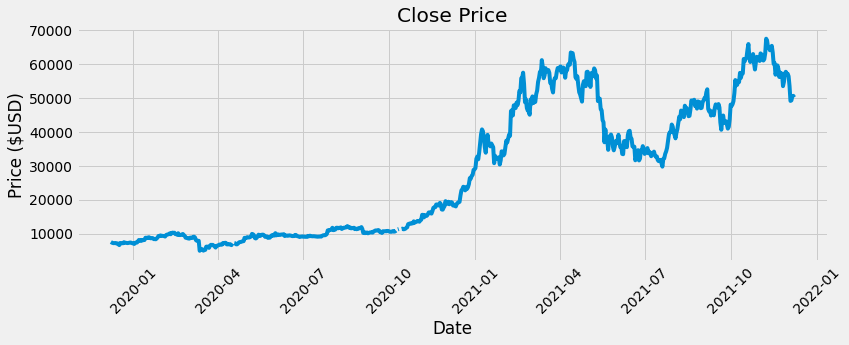

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df.Close)
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($USD)')
plt.xticks(rotation=45)
plt.show()


In [12]:
# Calculate Fibonacci Retracement Levels
max_price = df['Close'].max()
min_price = df['Close'].min()

difference = max_price - min_price
first_level = max_price - difference * 0.236
second_level = max_price - difference * 0.382
third_level = max_price - difference * 0.5
fourth_level = max_price - difference * 0.618

In [13]:
# Calculate MACD and Signal Line indicators
short_EMA = df.Close.ewm(span=12, adjust=False).mean()
long_EMA = df.Close.ewm(span=26, adjust=False).mean()
MACD = short_EMA - long_EMA
signal = MACD.ewm(span=9, adjust=False).mean()

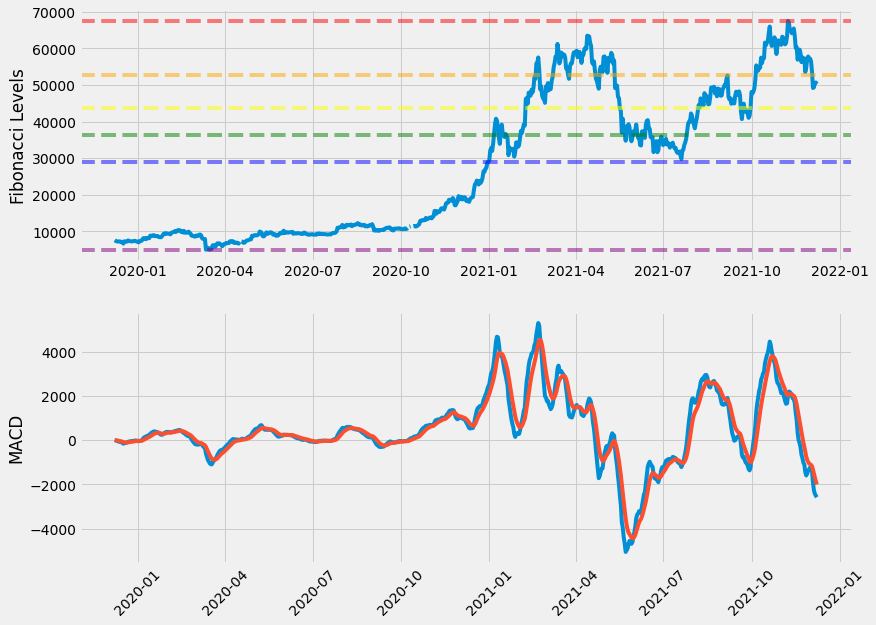

In [18]:
# Plot Fibonacci Levels with close price and MACD Signal line
new_df = df
plt.figure(figsize=(12.33, 9.5))
plt.subplot(2,1,1)
plt.plot(new_df.index, new_df['Close'])
plt.axhline(max_price, linestyle='--', alpha=0.5, color='red')
plt.axhline(first_level, linestyle='--', alpha=0.5, color='orange')
plt.axhline(second_level, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(third_level, linestyle='--', alpha=0.5, color='green')
plt.axhline(fourth_level, linestyle='--', alpha=0.5, color='blue')
plt.axhline(min_price, linestyle='--', alpha=0.5, color='purple')
plt.ylabel('Fibonacci Levels')

# Plot MACD line and Signal line
plt.subplot(2,1,2)
plt.plot(new_df.index, MACD)
plt.plot(new_df.index, signal)
plt.ylabel('MACD')
plt.xticks(rotation=45)

plt.show()

In [19]:
# Create new columns 
df['MACD'] = MACD
df['Signal Line'] = signal

In [20]:
# To generate upper and lower fibonacci level of current price
def getLevels(price):
    if price >= first_level:
        return (max_price, first_level)
    elif price >= second_level:
        return (first_level, second_level)
    elif price >= third_level:
        return (second_level, third_level)
    elif price >= fourth_level:
        return (third_level, fourth_level)
    else:
        return (fourth_level, min_price)
    

In [24]:
# Strategy: buy if signal > macd & current price crosses last fibonacci level 
def strategy(data):
    buy = []
    sell = []
    isHolding = False
    lastBoughtPrice = 0
    
    for i in range(0, data.shape[0]):
        closePrice = data['Close'][i]
        # Get level above and below first data point
        if i == 0:
            upper_level, lower_level = getLevels(closePrice)
            buy.append(np.nan)
            sell.append(np.nan)
        # Current price >= upper level or less than equal to lower level, then price crossed new level
        elif closePrice >= upper_level or closePrice <= lower_level:
            # Check if MACD line crossed above or below signal
            if data['Signal Line'][i] > data['MACD'][i] and not isHolding:
                buy.append(closePrice)
                sell.append(np.nan)
                lastBoughtPrice = closePrice
                isHolding = True
            elif data['Signal Line'][i] < data['MACD'][i] and isHolding:
                buy.append(np.nan)
                sell.append(closePrice)
                isHolding = False
            else:
                buy.append(np.nan)
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
        
        # Update fibonacci levels
        upper_level, lower_level = getLevels(closePrice)
    
    return buy, sell

In [25]:
buy, sell = strategy(df)
df['Buy_Signal_Price'] = buy
df['Sell_Signal_Price'] = sell
df

,Date,Open,High,Low,Close,Volume,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price
2019-12-08,2019-12-08,7551.338867,7634.606445,7476.091309,7564.345215,1.540991e+10,0.000000,0.000000,NaN,NaN
2019-12-09,2019-12-09,7561.795410,7618.091797,7365.985352,7400.899414,1.787202e+10,-13.038411,-2.607682,NaN,NaN
2019-12-10,2019-12-10,7397.134277,7424.022949,7246.043945,7278.119629,1.824903e+10,-32.899504,-8.666047,NaN,NaN
2019-12-11,2019-12-11,7277.197754,7324.156250,7195.527344,7217.427246,1.635049e+10,-52.926824,-17.518202,NaN,NaN
2019-12-12,2019-12-12,7216.738770,7266.639648,7164.741211,7243.134277,1.892708e+10,-65.963885,-27.207339,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-12-04,2021-12-04,53727.878906,53904.679688,42874.617188,49200.703125,6.138568e+10,-1922.827523,-1329.550333,NaN,NaN
2021-12-05,2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656,3.719820e+10,-2274.975367,-1518.635340,NaN,NaN
2021-12-06,2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000,3.770731e+10,-2428.123486,-1700.532969,NaN,NaN
2021-12-07,2021-12-07,50581.828125,51934.781250,50175.808594,50700.085938,3.367681e+10,-2511.070302,-1862.640436,NaN,NaN


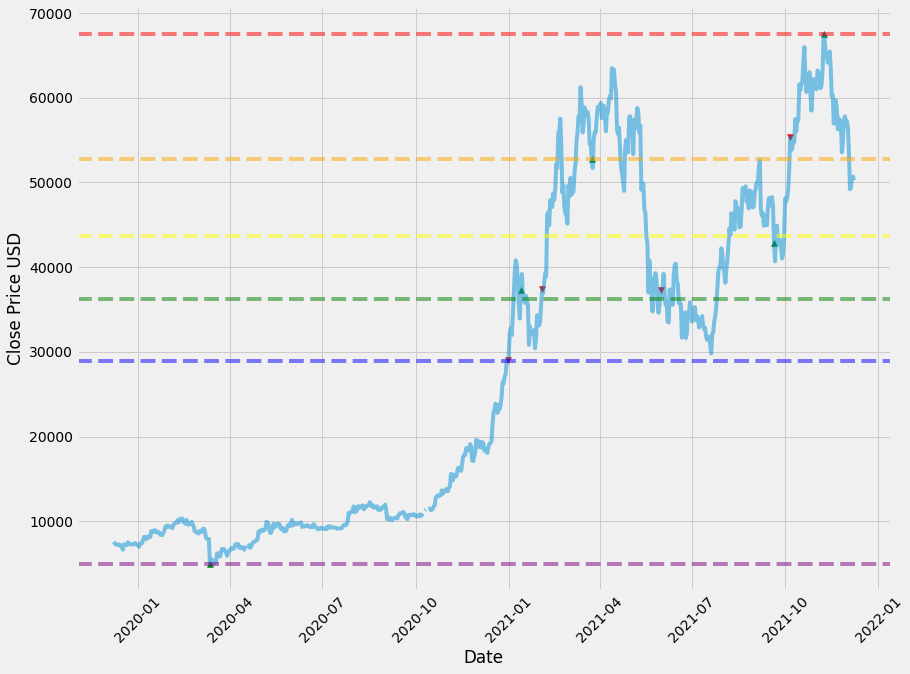

In [29]:
#Plot Fibonacci levels along close Price
plt.figure(figsize=(13, 10))
plt.plot(df.index, df['Close'], alpha=0.5)
plt.scatter(df.index, df['Buy_Signal_Price'], color='green', marker='^', alpha=1)
plt.scatter(df.index, df['Sell_Signal_Price'], color='red', marker='v', alpha=1)

plt.axhline(max_price, linestyle='--', alpha=0.5, color='red')
plt.axhline(first_level, linestyle='--', alpha=0.5, color='orange')
plt.axhline(second_level, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(third_level, linestyle='--', alpha=0.5, color='green')
plt.axhline(fourth_level, linestyle='--', alpha=0.5, color='blue')
plt.axhline(min_price, linestyle='--', alpha=0.5, color='purple')

plt.ylabel('Close Price USD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

Closing thoughts: Fibonacci retracement levels for the entire historical timeframe gives the support and resistance level. A more effective use of fibonnaci retracement would be to calaculate the fibonacci retracement levels at smaller and more specific time frames to determine stop loss.